In [1]:
%cd /work/tomishima2904/explore_conceptnet
!ls

/work/tomishima2904/explore_conceptnet
Dockerfile  do_1.sh  docker-compose.yml  nohup.out	   src
datasets    do_2.sh  logfile.log	 requirements.txt  tmp
do_0.sh     do_3.sh  logs		 results	   venv


In [2]:
import csv
import json
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import re

# Labels.txt

In [5]:
# 手動で評価したデータをシンプルにテキストファイルで出力
result_dir = "results/ja/連想語頻度表/text_generation/231206204932_test3_15S_mAll"
input_path = f"{result_dir}/formatted_results_.txt"
output_path = f"{result_dir}/labels.txt"

num_pairs = 50
num_return_sequences = 3

with open(input_path, 'r') as f:
    input_data = [line for line in f if line.strip()]

with open(output_path, 'w') as f:
    for i in range(num_pairs):
        head, tail = (input_data[(num_return_sequences+1)*i]).split(", ")
        tail = tail.rstrip("\n")
        labels = [int(input_data[j][0]) for j in range((num_return_sequences+1)*i+1, (num_return_sequences+1)*(i+1))]
        assert len(labels) == num_return_sequences
        f.write(f"{sum(labels)}\n")

# 事前の予備実験

## 2023/10/20 Execution Accuracyを元にFew-shotのdemonstrationsを選定

In [3]:
result_dir = "results/ja/連想語頻度表/text_generation/231023085912_dev_1.0_0s"
input_path = f"{result_dir}/rated_results.csv"
with open(input_path, 'r') as f:
    reader = csv.reader(f)
    input_data = [[*row[:3], eval(row[3]), eval(row[4])] for row in reader]

In [4]:
input_data.sort(key=lambda x: x[-1][0][0] + x[-1][0][1])

In [5]:
for i, row in enumerate(input_data):
    print(f"{i}: {row[0]} {row[1]} {row[2]} {row[-1][0]}")

0: /r/Antonym 危険 安全 (0, 0)
1: /r/AtLocation イルカ 水族館 (0, 0)
2: /r/Antonym 自然 人工 (0, 1)
3: /r/MadeOf タイヤ ゴム (0, 1)
4: /r/MadeOf ビール 麦 (0, 1)
5: /r/Synonym 火災 火事 (1, 1)
6: /r/Synonym 名前 氏名 (1, 2)
7: /r/IsA 男 性別 (0, 4)
8: /r/AtLocation 石油 アラブ (0, 8)
9: /r/AtLocation ボート 湖 (4, 14)
10: /r/IsA ワルツ ダンス (21, 9)
11: /r/MadeOf 机 木 (100, 8)
12: /r/PartOf 画面 パソコン (100, 90)
13: /r/AtLocation ソファ リビング (1000, 0)
14: /r/IsA チーズ 乳製品 (0, 1000)
15: /r/PartOf かかと 足 (1000, 0)
16: /r/AtLocation カエル 池 (1000, 1)
17: /r/PartOf ふもと 山 (1000, 2)
18: /r/IsA くじら 哺乳類 (1000, 100)


In [6]:
template = "与えられた入力語から出力語が連想される理由について解答しなさい。\n"
demonstrations = [1, 3, 5, 10, 12]
for i in demonstrations:
    template += f"入力語:{input_data[i][1]} 出力語:{input_data[i][2]}\n連想の理由:{input_data[i][3][0]}\n\n"
template += "入力語:{head} 出力語:{tail}\n連想の理由:"

with open(f'{result_dir}/template.txt', 'w') as f:
    print(template)
    print(repr(template), file=f)
    template = template.replace("\n", " ")
    print(template, file=f)

与えられた入力語から出力語が連想される理由について解答しなさい。
入力語:イルカ 出力語:水族館
連想の理由:イルカは海に住む哺乳動物で、水族館は海に潜って動物を見ることを目的に作られた施設です

入力語:タイヤ 出力語:ゴム
連想の理由:タイヤはゴムでできているから タイヤはゴムでできている

入力語:火災 出力語:火事
連想の理由: 入力語が「火災」であるため、出力語は「火事」である

入力語:ワルツ 出力語:ダンス
連想の理由: 1 入力語「ワルツ」は、語尾が「～」で終わることから、「ダンス」に連想される

入力語:画面 出力語:パソコン
連想の理由: 入力語の「パソコン」と出力語の「画面」とを関連づける

入力語:{head} 出力語:{tail}
連想の理由:


## 2023/10/29 Zero-shotのcompletionsの中に正解はあるのか

In [18]:
result_dir = "results/ja/連想語頻度表/text_generation/231031120400_dev30_M10_0S_0R"
input_path = f"{result_dir}/formatted_results_.txt"
output_path = f"{result_dir}/manually_rated_results.csv"

num_return_sequences = 30
num_pairs = 25
relations_list = ["/r/AtLocation", "/r/IsA", "/r/MadeOf", "/r/PartOf", "/r/Synonym"]

with open(input_path, 'r') as rf:
    input_data = [line for line in rf if line.strip()]
    assert len(input_data) == (num_return_sequences + 1) * num_pairs

with open(output_path, 'w') as wf:
    writer = csv.writer(wf)
    for i in range(num_pairs):
        rel, head, tail = (input_data[(num_return_sequences+1)*i]).split(", ")
        tail = tail.rstrip("\n")
        label = []
        assert rel.startswith("/r")
        if rel not in relations_list:
            continue
        else:
            label = [int(input_data[j][0]) for j in range((num_return_sequences+1)*i+1, (num_return_sequences+1)*(i+1))]
            assert len(label) == num_return_sequences
            writer.writerow((rel, head, tail, label))


# 2023/10/30 手動評価と自動評価の比較

1. zero-shotで連想の理由を30個生成していてその中からMLMを使って補完文を評価している
2. そもそも補完文の中に連想の理由をちゃんと述べているもの（few-shotのdemonstrationに相応しいもの）はあるのか
3. 2を調査するために手動でふさわしいものには1をそうでないものには0をラベル付
4. 自動で評価された逆順位のスコアと手動で評価されたラベルとの間に相関はあるのか

- 2023/11/07: 以下の関数を`m_and_a_comparator.py`で自動化しました

## 個人（1つのラベル付データに対する処理）

In [13]:
# 手動評価と自動評価の結果をまとめたファイル`diffs_btween_manda.csv`を作成
root_dir = "results/ja/連想語頻度表/text_generation/231102101933_dev30_C7_0S_0R"
model_name = "Cyber7-1"

input_path_a = f"{root_dir}/rated_results.csv"
input_path_m = f"{root_dir}/formatted_results_.txt"
output_path_all = f"{root_dir}/diffs_btween_manda.csv"
output_dir = f"{root_dir}/diffs_btween_manda"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

num_return_sequences = 30
num_pairs = 25

with open(input_path_m, 'r') as mf, open(input_path_a, 'r') as af:
    input_data_m = [line for line in mf if line.strip()]
    assert len(input_data_m) == (num_return_sequences + 1) * num_pairs
    a_reader = csv.reader(af)
    input_data_a = [line for line in a_reader]
    """input_data_a
    0) rel: str
    1) head: str
    2) tail: str
    3) completions: List[str]
    4) ranks: List[Tuple(int, int)]
    5) rrs: List[Tuple(float, float)]
    """

with open(output_path_all, 'w') as wf:
    writer = csv.writer(wf)
    for i in range(num_pairs):
        rel, head, tail = (input_data_m[(num_return_sequences+1)*i]).split(", ")
        tail = tail.rstrip("\n")
        output_path = f"{root_dir}/"
        assert head == input_data_a[i][1] and tail == input_data_a[i][2], f"{head} & {input_data_a[i][1]}; {tail} & {input_data_a[i][2]}"
        label_m = [int(input_data_m[j][0]) for j in range((num_return_sequences+1)*i+1, (num_return_sequences+1)*(i+1))]
        assert len(label_m) == num_return_sequences
        # completions_m = [(input_data_m[j][2:]).rstrip("\n") for j in range((num_return_sequences+1)*i+1, (num_return_sequences+1)*(i+1))]
        completions_a = [completion_a for completion_a in eval(input_data_a[i][3])]
        ranks_a = [rank for rank in eval(input_data_a[i][4])]
        rrs_a = [rr for rr in eval(input_data_a[i][5])]
        
        # MRRの和をキーに全て降順にソートする
        sorted_rrs_indices = sorted(range(num_return_sequences), key=lambda i: rrs_a[i][0]+rrs_a[i][1], reverse=True)
        sorted_ranks = [ranks_a[j] for j in sorted_rrs_indices]
        sorted_rrs = [rrs_a[j] for j in sorted_rrs_indices]
        sorted_labels_m = [label_m[j] for j in sorted_rrs_indices]
        sorted_completions = [completions_a[j] for j in sorted_rrs_indices]

        # 全体の結果を1行に出力
        output_row = [rel, head, tail, sorted_completions, sorted_ranks, sorted_rrs, sorted_labels_m]
        writer.writerow(output_row)

        # 各completionの結果に関して個別のファイルに出力
        output_path_detail = f"{output_dir}/{rel.lstrip('/r/')}_{head}_{tail}.csv"
        with open(output_path_detail, 'w') as f:
            writer_detail = csv.writer(f)
            writer_detail.writerow((rel, head, tail))
            for cpl, rank, rr, label in zip(sorted_completions, sorted_ranks, sorted_rrs, sorted_labels_m):
                writer_detail.writerow((cpl, rank, rr, label))
            
print(f"Successfully dumple {output_path_all}!")

Successfully dumple results/ja/連想語頻度表/text_generation/231102101933_dev30_C7_0S_0R/diffs_btween_manda.csv!


In [14]:
# 手動でラベル付した結果をエクセルにコピペしやすいように`labels.txt`を出力
output_path = f"{root_dir}/labels.txt"

with open(input_path, 'r') as rf, open(output_path, 'w') as wf:
    reader = csv.reader(rf)
    labels = [eval(row[-1]) for row in reader]
    for row in labels:
        label_sum = sum(row)
        wf.write(f"{label_sum}\n")

In [15]:
# 散布図用にデータ加工
input_path = f"{root_dir}/diffs_btween_manda.csv"
topk=100

with open(input_path, 'r') as f:
    reader = csv.reader(f)
    all_input_data = [row for row in reader]

all_head_rrs_f = []
all_head_rrs_t = []
all_tail_rrs_f = []
all_tail_rrs_t = []
in_sentence_head_rrs_f = []
in_sentence_head_rrs_t = []
in_sentence_tail_rrs_f = []
in_sentence_tail_rrs_t = []
for row in all_input_data:
    for rank_pair, rr_pair, label in zip(eval(row[4]), eval(row[5]), eval(row[6])):
        label = int(label)
        head_rank, tail_rank = rank_pair
        head_rr, tail_rr = rr_pair
        if label == 1:
            all_head_rrs_t.append(head_rr)
            all_tail_rrs_t.append(tail_rr)
            if head_rank < topk*10 and tail_rank < topk*10:
                in_sentence_head_rrs_t.append(head_rr)
                in_sentence_tail_rrs_t.append(tail_rr)
        else:
            all_head_rrs_f.append(head_rr)
            all_tail_rrs_f.append(tail_rr)
            if head_rank < topk*10 and tail_rank < topk*10:
                in_sentence_head_rrs_f.append(head_rr)
                in_sentence_tail_rrs_f.append(tail_rr)
print(f"head_f: {len(in_sentence_head_rrs_f)}/{len(all_head_rrs_f)}")
print(f"tail_f: {len(in_sentence_tail_rrs_f)}/{len(all_tail_rrs_f)}")
print(f"head_t: {len(in_sentence_head_rrs_t)}/{len(all_head_rrs_t)}")
print(f"tail_t: {len(in_sentence_tail_rrs_t)}/{len(all_tail_rrs_t)}")

head_f: 209/687
tail_f: 209/687
head_t: 58/63
tail_t: 58/63


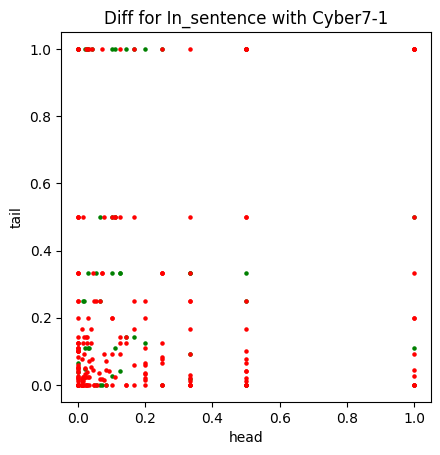

In [16]:
# 散布図（completion中にheadとtailどちらも含まれる場合）
plt.axes().set_aspect('equal')
plt.scatter(in_sentence_head_rrs_t, in_sentence_tail_rrs_t, c="green", s=5)
plt.scatter(in_sentence_head_rrs_f, in_sentence_tail_rrs_f, c="red", s=5)
plt.xlabel("head")
plt.ylabel("tail")
plt.title(f"Diff for In_sentence with {model_name}")

fig_path = f"{root_dir}/diff_in_sentence.png"
plt.savefig(fig_path)

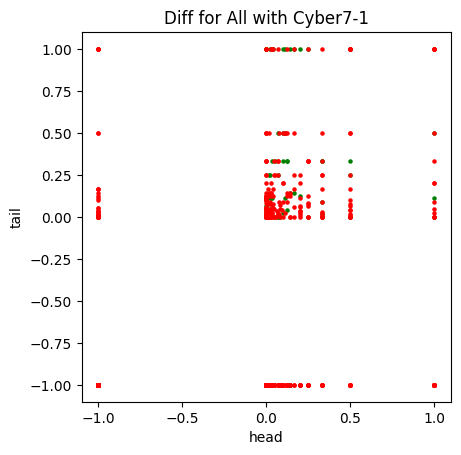

In [17]:
# 散布図（全部載せ）
plt.axes().set_aspect('equal')
plt.scatter(all_head_rrs_t, all_tail_rrs_t, c="green", s=5)
plt.scatter(all_head_rrs_f, all_tail_rrs_f, c="red", s=5)
plt.xlabel("head")
plt.ylabel("tail")
plt.title(f"Diff for All with {model_name}")

fig_path = f"{root_dir}/diff_all.png"
plt.savefig(fig_path)

In [24]:
# 折れ線グラフ用にcompletionsに対するラベルを逆順位の和でソートしたものを準備
root_dir = "results/ja/連想語頻度表/text_generation/231102101933_dev30_C7_0S_0R"
model_name = "Cyber7-1"

input_path = f"{root_dir}/diffs_btween_manda.csv"
completions_num=30
row_num_per_rel_type = 5
rel_type_num = 5

with open(input_path, 'r') as f:
    reader = csv.reader(f)
    input_data = [row for row in reader]

all_labels = np.array([eval(row[-1]) for row in input_data])
all_rrs = [eval(row[5]) for row in input_data]
all_mrrs = np.array([[np.average(pair) for pair in row] for row in all_rrs])
assert all_labels.shape == tuple((rel_type_num*row_num_per_rel_type, completions_num))
rels = [row[0] for row in input_data]
assert len(rels) == rel_type_num*row_num_per_rel_type

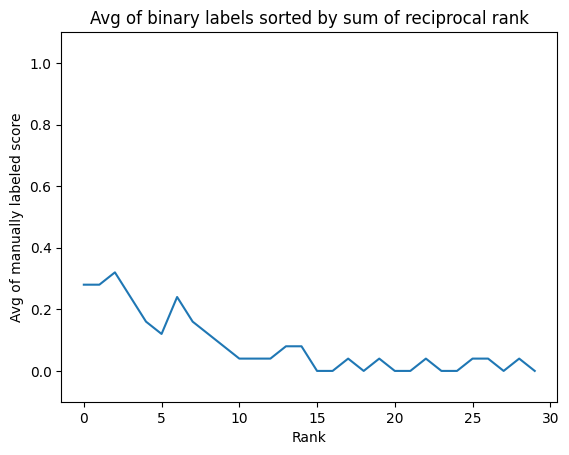

In [25]:
# 折れ線グラフ
avg_labels = np.average(all_labels, axis=0)
plt.plot(range(len(avg_labels)), avg_labels)
plt.title("Avg of binary labels sorted by sum of reciprocal rank")
plt.xlabel("Rank")
plt.ylabel("Avg of manually labeled score")
plt.ylim(-0.1,1.1)
fig_path = f"{root_dir}/line_plot_all.png"
plt.savefig(fig_path)

In [26]:
# rel typeごとに折れ線グラフ

labels_dict = {}
output_dir = f"{root_dir}/line_plots"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

for i in range(rel_type_num):
    labels_dict[rels[i*row_num_per_rel_type]] = np.array([row for row in all_labels[i*row_num_per_rel_type:(i+1)*row_num_per_rel_type]])

for rel, labels in labels_dict.items():
    avg_labels = np.average(labels, axis=0)

    plt.figure()
    plt.title(f"Avg dim=0 {rel.lstrip('/r/')}")
    plt.xlabel("Rank")
    plt.ylabel("Avg of manually labeled score")
    plt.ylim(-0.1,1.1)
    plt.plot(range(len(avg_labels)), avg_labels)

    plt.savefig(f"{output_dir}/line_plot_{rel.lstrip('/r/')}.png")
    plt.close()

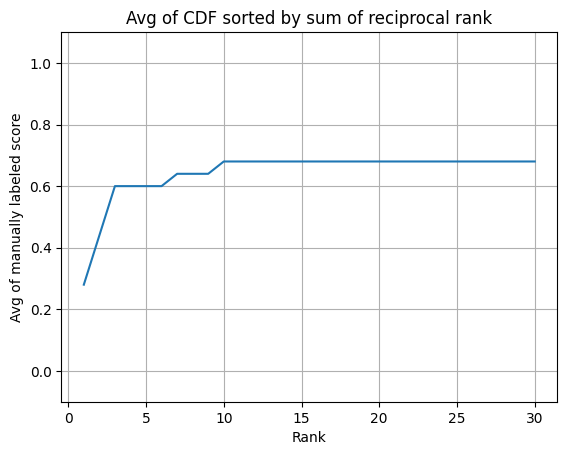

In [27]:
# 累積折れ線グラフをプロット
cumulative_labels = np.array([[any(labels[:i+1]) for i in range(len(labels))] for labels in all_labels])
avg_cumulative_labels = np.average(cumulative_labels, axis=0)
plt.plot(range(1, len(avg_cumulative_labels)+1), avg_cumulative_labels)
plt.title("Avg of CDF sorted by sum of reciprocal rank")
plt.xlabel("Rank")
plt.ylabel("Avg of manually labeled score")
plt.ylim(-0.1,1.1)
plt.grid()
fig_path = f"{root_dir}/line_plot_cdf.png"
plt.savefig(fig_path)

# ついでにcsvも出力
output_path1 = f"{root_dir}/cdf_all.csv"
output_path2 = f"{root_dir}/mrr.csv"
with open(output_path1, 'w') as wf1, open(output_path2, 'w') as wf2:
    writer1 = csv.writer(wf1)
    writer2 = csv.writer(wf2)
    for row, labels, mrr in zip(input_data, cumulative_labels, all_mrrs):
        labels = [int(l) for l in labels]
        writer1.writerow([*row[:3], *labels])
        writer2.writerow([*row[:3], *mrr])

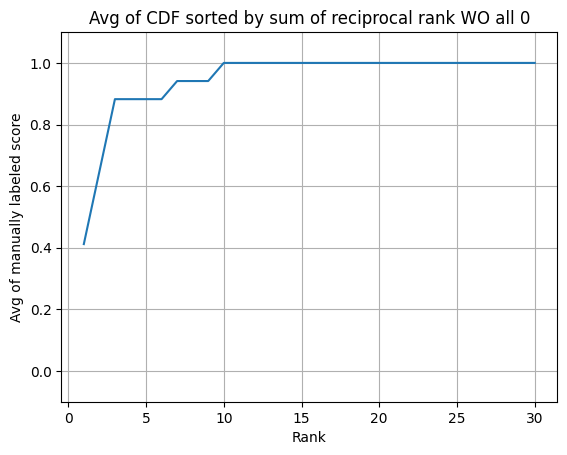

In [28]:
# 累積折れ線グラフで全てラベルが0のものを除いた場合
cumulative_labels_wo_all0 = np.array([labels for labels in cumulative_labels if any(labels)])
avg_cumulative_labels_wo_all0 = np.average(cumulative_labels_wo_all0, axis=0)
plt.plot(range(1, len(avg_cumulative_labels_wo_all0)+1), avg_cumulative_labels_wo_all0)
plt.title("Avg of CDF sorted by sum of reciprocal rank WO all 0")
plt.xlabel("Rank")
plt.ylabel("Avg of manually labeled score")
plt.ylim(-0.1,1.1)
plt.grid()
fig_path = f"{root_dir}/line_plot_cdf_wo_all0.png"
plt.savefig(fig_path)

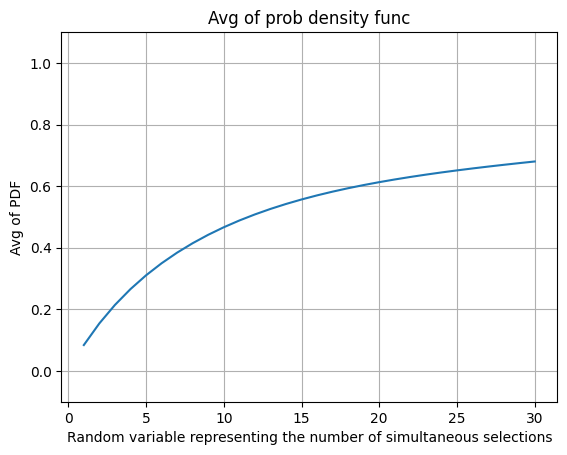

In [29]:
# x個同時にランダムにラベルを取得した時少なくとも1つ以上当たりが含まれる確率を計算する (xは確率変数)

# x個同時にとった時，全て外れである確率を求めるための下準備
probability_spaces = np.array([[(len(row)-sum(row)-i)/(len(row)-i) if len(row)-sum(row)-i>0 else 0 for i in range(len(row))]
        for row in all_labels])

# x個同時にとった時，全て外れである確率を求める (xは確率変数)
at_least_prob_spaces = [[1-np.prod(row[:i+1]) for i in range(len(row))] for row in probability_spaces]

# バッチ方向に平均をとってグラフ出力
avg_at_least_prob_spaces = np.average(at_least_prob_spaces, axis=0)
plt.plot(range(1, len(avg_at_least_prob_spaces)+1), avg_at_least_prob_spaces)
plt.title("Avg of prob density func")
plt.xlabel("Random variable representing the number of simultaneous selections")
plt.ylabel("Avg of PDF")
plt.ylim(-0.1,1.1)
plt.grid()
fig_path = f"{root_dir}/line_plot_avg_of_pdf.png"
plt.savefig(fig_path)

# ついでにcsvも出力
output_path = f"{root_dir}/avg_of_pdf.csv"
with open(output_path, 'w') as wf:
    writer = csv.writer(wf)
    for row, pdf in zip(input_data, at_least_prob_spaces):
        writer.writerow([*row[:3], *pdf])

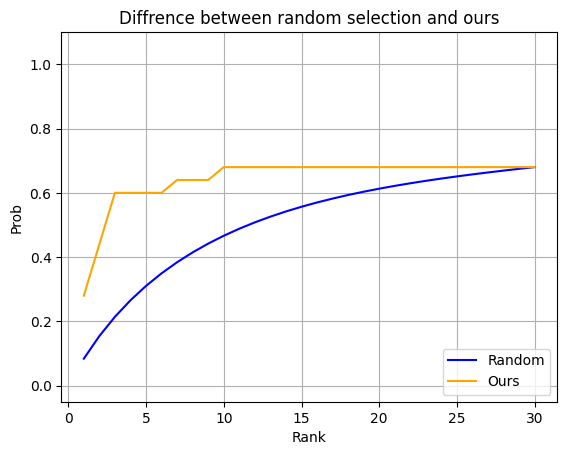

In [30]:
plt.plot(range(1, len(avg_at_least_prob_spaces)+1), avg_at_least_prob_spaces, c="blue", label="Random")
plt.plot(range(1, len(avg_cumulative_labels)+1), avg_cumulative_labels, c="orange", label="Ours")
plt.title("Diffrence between random selection and ours")
plt.xlabel("Rank")
plt.ylabel("Prob")
plt.legend(loc="lower right")
plt.xlim()
plt.ylim(-0.05,1.1)
plt.grid()
fig_path = f"{root_dir}/line_plot_difference.png"
plt.savefig(fig_path)

## 複数（3人によるラベル付データの処理）on 2023/11/20
m_and_a_comparator.pyとresult_formmaterに役割を委譲しました

In [3]:
# 3人のラベル付データを統合する
input_paths = ["results/ja/連想語頻度表/text_generation/231031120400_dev30_M10_0S_0R/formatted_results_R.txt",
               "results/ja/連想語頻度表/text_generation/231031120400_dev30_M10_0S_0R/formatted_results_T.txt",
               "results/ja/連想語頻度表/text_generation/231031120400_dev30_M10_0S_0R/formatted_results_Y.txt"]

In [1]:
def convert_formatted_results_tolist(input_path: str, num_return_sequences=30, num_pairs=25):
    """output_data
    0) rel: str
    1) head: str
    2) tail: str
    3) completions: List[str]
    4) labels: List[int]
    """
    with open(input_path, 'r') as f:
        input_data = [line for line in f if line.strip()]
        assert len(input_data) == (num_return_sequences + 1) * num_pairs

    output_data = []
    for i in range(num_pairs):
        rel, head, tail = (input_data[(num_return_sequences+1)*i]).split(", ")
        tail = tail.rstrip("\n")
        labels = [int(input_data[j][0]) for j in range((num_return_sequences+1)*i+1, (num_return_sequences+1)*(i+1))]
        assert len(labels) == num_return_sequences
        completions = [(input_data[j][2:]).rstrip("\n") for j in range((num_return_sequences+1)*i+1, (num_return_sequences+1)*(i+1))]
        output_data.append([rel, head, tail, completions, labels])
    return output_data

In [11]:
# 3人がラベル付した結果を統合
all_labels = []
num_return_sequences = 30
num_pairs = 25

for input_path in input_paths:
    labeled_data = convert_formatted_results_tolist(input_path)
    labeles = [row[-1] for row in labeled_data]
    all_labels.append(labeles)

all_labels = np.array(all_labels)
assert all_labels.shape == (len(input_paths), num_pairs, num_return_sequences), f"{all_labels.shape} != {(len(input_paths), num_pairs, num_return_sequences)}"

summed_all_labels = np.sum(all_labels, axis=0)
summed_all_labels.shape

(25, 30)

In [ ]:
root_dir = "results/ja/連想語頻度表/text_generation/231102101933_dev30_C7_0S_0R"

input_path = f"{root_dir}/rated_results.csv"
output_path_all = f"{root_dir}/diffs_btween_manda.csv"
output_dir = f"{root_dir}/diffs_btween_manda"

In [ ]:
# 手動評価と自動評価の結果をまとめたファイル`diffs_btween_manda.csv`を作成
root_dir = "results/ja/連想語頻度表/text_generation/231102101933_dev30_C7_0S_0R"
model_name = "Cyber7-1"

input_path_a = f"{root_dir}/rated_results.csv"
input_path_m = f"{root_dir}/formatted_results_.txt"
output_path_all = f"{root_dir}/diffs_btween_manda.csv"
output_dir = f"{root_dir}/diffs_btween_manda"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

num_return_sequences = 30
num_pairs = 25



with open(input_path_m, 'r') as mf, open(input_path_a, 'r') as af:
    input_data_m = [line for line in mf if line.strip()]
    assert len(input_data_m) == (num_return_sequences + 1) * num_pairs
    a_reader = csv.reader(af)
    input_data_a = [line for line in a_reader]
    """input_data_a
    0) rel: str
    1) head: str
    2) tail: str
    3) completions: List[str]
    4) ranks: List[Tuple(int, int)]
    5) rrs: List[Tuple(float, float)]
    """

with open(output_path_all, 'w') as wf:
    writer = csv.writer(wf)
    for i in range(num_pairs):
        rel, head, tail = (input_data_m[(num_return_sequences+1)*i]).split(", ")
        tail = tail.rstrip("\n")
        output_path = f"{root_dir}/"
        assert head == input_data_a[i][1] and tail == input_data_a[i][2], f"{head} & {input_data_a[i][1]}; {tail} & {input_data_a[i][2]}"
        label_m = [int(input_data_m[j][0]) for j in range((num_return_sequences+1)*i+1, (num_return_sequences+1)*(i+1))]
        assert len(label_m) == num_return_sequences
        # completions_m = [(input_data_m[j][2:]).rstrip("\n") for j in range((num_return_sequences+1)*i+1, (num_return_sequences+1)*(i+1))]
        completions_a = [completion_a for completion_a in eval(input_data_a[i][3])]
        ranks_a = [rank for rank in eval(input_data_a[i][4])]
        rrs_a = [rr for rr in eval(input_data_a[i][5])]
        
        # MRRの和をキーに全て降順にソートする
        sorted_rrs_indices = sorted(range(num_return_sequences), key=lambda i: rrs_a[i][0]+rrs_a[i][1], reverse=True)
        sorted_ranks = [ranks_a[j] for j in sorted_rrs_indices]
        sorted_rrs = [rrs_a[j] for j in sorted_rrs_indices]
        sorted_labels_m = [label_m[j] for j in sorted_rrs_indices]
        sorted_completions = [completions_a[j] for j in sorted_rrs_indices]

        # 全体の結果を1行に出力
        output_row = [rel, head, tail, sorted_completions, sorted_ranks, sorted_rrs, sorted_labels_m]
        writer.writerow(output_row)

        # 各completionの結果に関して個別のファイルに出力
        output_path_detail = f"{output_dir}/{rel.lstrip('/r/')}_{head}_{tail}.csv"
        with open(output_path_detail, 'w') as f:
            writer_detail = csv.writer(f)
            writer_detail.writerow((rel, head, tail))
            for cpl, rank, rr, label in zip(sorted_completions, sorted_ranks, sorted_rrs, sorted_labels_m):
                writer_detail.writerow((cpl, rank, rr, label))
            
print(f"Successfully dumple {output_path_all}!")


## 2023/11/07 自動評価されたcompletionsの質を実際に見てみる

In [ ]:
result_dir = "results/ja/連想語頻度表/text_generation/231102101933_dev30_C7_0S_0R"
input_path = f"{result_dir}/diffs_btween_manda.csv"

num_output_completions = 5
output_path = f"{result_dir}/diffs_btween_manda_formatted{num_output_completions}.txt"

with open(input_path, 'r') as rf, open(output_path, 'w') as wf:
    reader = csv.reader(rf)
    for row in reader:
        wf.write(f"{row[0]} {row[1]} {row[2]}\n")
        for completion, label in zip(eval(row[3]), eval(row[6])):
            if i >= num_output_completions:
                break
            else:
                wf.write(f"{label},{completion}\n")
        wf.write("\n")

# 2023/11/10 手動評価したデータをcsvとテキストファイルに出力

## Softmax score や 文長で選出したcompletinがどのくらい正解ラベルを含んでいるか

In [17]:
input_path = f"results/ja/連想語頻度表/text_generation/231031120400_dev30_M10_0S_0R/m_and_a/softmax/diffs_btween_manda_formatted6.csv"
num_subjects = 3
threshold = (num_subjects+1)//2

with open(input_path, 'r') as f:
    reader = csv.reader(f)
    input_data = [row for row in reader]

first_labels = (np.array([eval(row[-1])[0] for row in input_data]) > threshold).astype(int)
print("SOFTMAX")
print(f"{first_labels}")
print(f"Sum: {sum(first_labels)}/{len(first_labels)}")
print(f"Avg: {sum(first_labels)/len(first_labels)}")

SOFTMAX
[1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Sum: 7/25
Avg: 0.28


In [14]:
# テンプレートをチラ見するだけ
input_path = "datasets/連想語頻度表/templates/few-shot_no_refs_6.json"
with open(input_path, 'r') as f:
    input_data = json.load(f)
    print(input_data["prompt_input"])

与えられた入力語から出力語が連想される理由について解答しなさい。
入力語:ピアノ 出力語:楽器
連想の理由:ピアノは楽器の1つだからです

入力語:イルカ 出力語:水族館
連想の理由:イルカは水族館にいるからです

入力語:テニス 出力語:スポーツ
連想の理由:テニスはスポーツの1つだからです

入力語:うどん 出力語:小麦粉
連想の理由:うどんは小麦粉からできているからです

入力語:空気 出力語:大気
連想の理由:空気と大気は同じだからです

入力語:{head} 出力語:{tail}
連想の理由:


# 2023/11/15 主観評価実験のためのデータ作成

In [30]:
# 被験者ID
subject_id = 12
str_subject_id = f"{subject_id:02}"

# 被験者に提示するためのデータをまとめるためのディレクトリ名を指定
base_directory = "results/ja/連想語頻度表/evaluation/master/"

# 指定のディレクトリ内のすべてのディレクトリをリストアップ
all_dirs = os.listdir(base_directory)

# subject_idの数字で終わるディレクトリ名を抽出
matching_dirs = [d for d in all_dirs if d.endswith(f"_{subject_id}")]
input_dirs = [os.path.join(base_directory, d) for d in matching_dirs]
input_dirs.sort()
for path in input_dirs:
    print(path)

# データをシャッフルし，実験用データを自動で作成
input_paths = [f"{input_dir}/formatted_results.csv" for input_dir in input_dirs]
all_input_data = []
for i, input_path in enumerate(input_paths):
    with open(input_path, 'r') as f:
        reader = csv.reader(f)
        input_data = [row for row in reader]
        all_input_data.append(input_data)

output_dir = f"results/ja/連想語頻度表/evaluation/master/{str_subject_id}"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

output_path1 = f"{output_dir}/irhtjs_50.csv"  # 被験者に提示するための複数のデータを1つにまとめたもの
output_path2 = f"{output_dir}/irhtjs_50_shuffled.csv"  # irhtjs_50をシャッフルしたもの
output_path3 = f"{output_dir}/shuffled_texts.txt"  # 被験者に提示する
num_pairs = 50
num_cpls = 3

with open(output_path1, 'w') as wf1, open(output_path2, 'w') as wf2, open(output_path3, 'w') as wf3:
    writer1 = csv.writer(wf1)
    writer2 = csv.writer(wf2)
    for i in range(num_pairs):
        row_set = []
        for j in range(len(input_paths)):
            for k in range(num_cpls):
                one_row = [*all_input_data[j][i][:4], num_cpls*j+k, eval(all_input_data[j][i][4])[k]]
                row_set.append(one_row)
                writer1.writerow(one_row)
        random.shuffle(row_set)
        writer2.writerows(row_set)

        wf3.write(f"{i+1}: {row_set[0][2]} → {row_set[0][3]}\n")
        for row in row_set:
            wf3.write(f",{row[-1]}\n")
        wf3.write("\n")

results/ja/連想語頻度表/evaluation/master/231115101840_12
results/ja/連想語頻度表/evaluation/master/231207113842_12
results/ja/連想語頻度表/evaluation/master/231207130535_12
results/ja/連想語頻度表/evaluation/master/231207135045_12
results/ja/連想語頻度表/evaluation/master/231207145248_12


# 主観評価実験の結果を集計

In [16]:
# 評価実験のデータを読み込んで，サイズ (被験者数, 刺激語と連想語ペアの数, 評価文数) のリスト作成
input_root_dir = "results/ja/連想語頻度表/evaluation/master"
subjects = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11]
input_dirs = [f"{input_root_dir}/{i:02}" for i in subjects]
file_names = [f"{input_dir}/shuffled_texts_{i}_.txt" for i, input_dir in zip(subjects, input_dirs)]

pattern = re.compile(r'^\d+,')
num_pairs = 50
num_return_seqs = 3
num_types = 5  # 評価を行う条件（提案手法，手動*3，自動ランダム）


all_results = []
for file_name in file_names:
    input_path = file_name
    result = []
    with open(input_path, 'r', encoding='utf-8') as f:
        print(input_path)
        text = f.read()
        lines = text.strip().split('\n')
        result = [int(line[0]) for line in lines if pattern.match(line)]
        shaped_result = [result[i*num_return_seqs*num_types:(i+1)*num_return_seqs*num_types] for i in range(num_pairs)]
        assert (np.array(shaped_result)).shape == (num_pairs, num_return_seqs*num_types), f"{(np.array(shaped_result)).shape}"
        all_results.append(shaped_result)
        # all_results.shape == (被験者数, 刺激語と連想語ペアの数, 評価文数)

print("Successfully read!")

results/ja/連想語頻度表/evaluation/master/01/shuffled_texts_1_.txt
results/ja/連想語頻度表/evaluation/master/02/shuffled_texts_2_.txt
results/ja/連想語頻度表/evaluation/master/04/shuffled_texts_4_.txt
results/ja/連想語頻度表/evaluation/master/05/shuffled_texts_5_.txt
results/ja/連想語頻度表/evaluation/master/06/shuffled_texts_6_.txt
results/ja/連想語頻度表/evaluation/master/07/shuffled_texts_7_.txt
results/ja/連想語頻度表/evaluation/master/08/shuffled_texts_8_.txt
results/ja/連想語頻度表/evaluation/master/09/shuffled_texts_9_.txt
results/ja/連想語頻度表/evaluation/master/10/shuffled_texts_10_.txt
results/ja/連想語頻度表/evaluation/master/11/shuffled_texts_11_.txt
Successfully read!


In [21]:
# マスターデータを読み込む
master_paths = [f"{input_dir}/irhtjs_50_shuffled.csv" for input_dir in input_dirs]
masters = []
for master_path in master_paths:
    with open(master_path, 'r') as f:
        reader = csv.reader(f)
        master = [int(row[4]) for row in reader]
        master = [master[i*num_return_seqs*num_types:(i+1)*num_return_seqs*num_types] for i in range(num_pairs)]
        assert (np.array(master)).shape == (num_pairs, num_return_seqs*num_types), f"{(np.array(master)).shape}"
        masters.append(master)

In [22]:
# 実験で答えた 0 or 1の配列を，すでに手元にあるマスターをもとに集計
def eval_using_master(shaped_result, master, num_types=5, num_return_seqs=3):
    compared_result = []
    type_ids = range(num_types)
    for result_row, master_row in zip(shaped_result, master):
        result_per_pair = []
        for type_id in type_ids:
            result_per_pair.append(sum([result_row[master_row.index(i)] for i in range(type_id*num_return_seqs, (type_id+1)*num_return_seqs)]))
        compared_result.append(result_per_pair)
    return compared_result

In [23]:
# 各被験者の結果を出力し，全被験者の評価実験の結果をまとめる shape==(num_pairs, num_types)
all_compared_results = []
for i, (result, master) in enumerate(zip(all_results, masters)):
    output_path = f"{input_dirs[i]}/scores.csv"
    assert (np.array(result)).shape == (np.array(master)).shape
    compared_result = eval_using_master(result, master)
    with open(output_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(compared_result)
    all_compared_results.append(compared_result)

In [27]:
# 全員の結果の和をとってcsv出力
final_result = np.sum(np.array(all_compared_results), axis=0)
print(final_result)

output_path = "results/ja/連想語頻度表/evaluation/master/final_result.csv"
with open(output_path, 'w') as f:
    writer = csv.writer(f)
    writer.writerows(final_result)

[[ 9  5  5  6  5]
 [ 3  0  6  3  5]
 [ 6  2  5  3  8]
 [ 5  0  2  1  3]
 [23 16 24 24 18]
 [22 26 27 28 15]
 [16 23 22 21 11]
 [16 25 25 25 17]
 [13 18 26 16  7]
 [21 22 27 26 13]
 [10 15 14 14  6]
 [11 11 20 18  7]
 [11  6 11 11  7]
 [10 10  8 12 10]
 [19 18 24 22 12]
 [11 10 22 21  8]
 [16 20 21 19  5]
 [12 13 13 12  9]
 [10 26 21 22  7]
 [20 25 28 26  9]
 [13 18 20 20  6]
 [21 24 26 25  6]
 [ 8  6 13  4  6]
 [22 13 20 14 13]
 [19 26 28 25  8]
 [14 14 23  5 11]
 [24 14 26 27 11]
 [ 7 15 17 15 15]
 [10  9 17  9  7]
 [11  9 21  9  1]
 [10 12 10 18 11]
 [10  3  7  2  5]
 [10 13 27 12 10]
 [22 21 24 22 19]
 [20 24 18 24 13]
 [10  7 10 11  4]
 [ 4 13 10 10  8]
 [12 12  4 11  6]
 [17 14 22 18 15]
 [21 25 25 23 17]
 [14 15 12 26 11]
 [11 19 20 22  6]
 [ 9 16 13 23 12]
 [12 14  9 21 11]
 [15 17 13 22 11]
 [22 21 28 25  8]
 [23 25 30 28 20]
 [13 12 23 24  7]
 [16 19 20 16 10]
 [19 13 23 18 11]]
